<div style="background: #f0f8ff; padding: 20px; border-left: 5px solid #3498db; border-radius: 10px; font-family: 'Segoe UI', sans-serif; text-align: center;">

<h2 style="color: #2c3e50; margin-bottom: 15px;">
  📘 Báo cáo phương pháp và kế hoạch triển khai chiến lược đầu tư
</h2>

<p style="font-size: 16px; line-height: 1.6; color: #34495e; display: inline-block; text-align: justify; max-width: 800px;">
  <strong>Mục tiêu:</strong> Xây dựng một chiến lược phân bổ vốn linh hoạt theo từng tháng (dưới dạng ma trận trọng số 12x4) nhằm tối đa hóa lợi nhuận đã điều chỉnh theo rủi ro cho danh mục 4 tài sản trong 12 tháng.
</p>

</div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

### 1. Lý giải phương pháp luận: Tối ưu hóa danh mục đa kỳ (Multi-Period Optimization)

#### **1.1. Vấn đề cốt lõi**
Bài toán yêu cầu một chiến lược **linh hoạt**, tức là quyết định phân bổ vốn không phải là một quyết định duy nhất ban đầu mà được điều chỉnh định kỳ ( theo như bỗi cảnh đã nói thì sẽ mua tài sản vào đầu mỗi tháng). Mục tiêu không chỉ là lợi nhuận cao nhất mà còn phải cân bằng với rủi ro chấp nhận được.

#### **1.2. Giải pháp đề xuất: Tối ưu hóa Trung bình-Phương sai (Mean-Variance Optimization - MVO) của Markowitz**
Đây là phương pháp nền tảng và phù hợp nhất cho bài toán này vì:
* **Giải quyết đúng mục tiêu**: MVO tập trung vào việc tìm kiếm danh mục đầu tư có **tỷ suất sinh lợi kỳ vọng cao nhất** cho một **mức rủi ro nhất định** (hoặc rủi ro thấp nhất cho một mức lợi nhuận nhất định). Điều này hoàn toàn khớp với mục tiêu cân bằng Lợi nhuận-Rủi ro của đề bài.
* **Cung cấp quyết định định lượng**: Thay vì dựa vào cảm tính, MVO cung cấp một vector trọng số (`w`) được tính toán dựa trên các dữ liệu thống kê, giúp quyết định phân bổ vốn trở nên khách quan.
* **Phù hợp với chiến lược đa kỳ**: Bằng cách áp dụng lặp lại thuật toán MVO vào đầu mỗi tháng với dữ liệu cập nhật, chúng ta có thể xây dựng được ma trận trọng số 12x4 một cách logic. Mỗi cột trong ma trận chính là kết quả của một bài toán tối ưu hóa tại một thời điểm.
* **Chúng tôi đã xem xét các phương pháp khác (arimax, lightGBM,...) Nhưng có quá ít dữ liệu và các biến liên quan** (đề cho 4 loại tài sản chứ ko có các biến liên quan như tỉ lệ lạm phát, giá nhiên liệu,... các yếu tố ảnh hưởng trực tiếp tới tất cả các loại tài sản) Và mô hình Markowitz thì không bắt buộc cần những biến đó để có khả năng hoạt động và tính giải thích


### 1. Load Cleaned Dataset

In [4]:
BASE_DIR = os.path.dirname(os.getcwd())
dataset_path = os.path.join(BASE_DIR, 'data', 'cleaned_data.csv')

# Load the dataset
data = pd.read_csv(dataset_path,  encoding='utf-8', parse_dates=['Time'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Time                    390 non-null    datetime64[ns]
 1   Crypto                  390 non-null    float64       
 2   Buying_Price_of_Nexus   390 non-null    float64       
 3   Selling_Price_of_Nexus  390 non-null    float64       
 4   Price_of_Stock          390 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 15.4 KB


In [6]:
data.head()

,Time,Crypto,Buying_Price_of_Nexus,Selling_Price_of_Nexus,Price_of_Stock
0,2024-05-20,4174.950000,1270.30,1272.56,113.456685
1,2024-05-21,4340.316717,1272.75,1277.70,114.961755
2,2024-05-22,4331.770000,1285.15,1287.88,110.453726
3,2024-05-23,4360.513317,1295.80,1297.22,110.921833
4,2024-05-24,4354.308333,1292.90,1297.53,109.518120


### 2. Chuẩn bị và Xử lý Dữ liệu Lợi nhuận (Returns)

Mô hình Markowitz không hoạt động trên giá mà trên tỷ suất sinh lợi (returns). Vì vậy, bước đầu tiên và quan trọng nhất là chuyển đổi dữ liệu giá thành dữ liệu tỷ suất sinh lợi theo tháng. Từ chuỗi giá hàng ngày, ta tính ra tỷ suất sinh lợi của mỗi tài sản vào cuối mỗi tháng.

Kết quả của bước này là một chuỗi thời gian về tỷ suất sinh lợi hàng tháng cho cả 4 loại tài sản (Tiết kiệm, Crypto, Cổ phiếu, Nexus).

In [7]:
monthly_returns = data.resample('M', on='Time').last().pct_change().dropna()
monthly_returns = monthly_returns.rename(columns={
    'Savings': 'Savings_Returns',
    'Crypto': 'Crypto_Returns',
    'Stocks': 'Stocks_Returns',
    'Nexus': 'Nexus_Returns'
})
monthly_returns = monthly_returns.reset_index()

In [8]:
monthly_returns

,Time,Crypto_Returns,Buying_Price_of_Nexus,Selling_Price_of_Nexus,Price_of_Stock
0,2024-06-30,-0.041761,-0.015514,-0.015570,-0.026694
1,2024-07-31,0.638053,-0.000697,-0.002274,0.087710
2,2024-08-31,0.609514,0.022666,0.024049,0.135544
3,2024-09-30,0.299394,0.006516,0.006714,-0.020638
4,2024-10-31,-0.411906,0.007980,0.007359,0.107178
5,2024-11-30,0.300935,-0.034281,-0.033757,0.162313
6,2024-12-31,-0.407258,-0.029156,-0.032126,-0.197499
7,2025-01-31,0.410697,-0.056558,-0.055290,0.043851
8,2025-02-28,-0.206954,0.002449,0.004580,-0.049332
9,2025-03-31,-0.136681,0.015414,0.014542,-0.175582


### 3. Dự báo Lợi nhuận Kỳ vọng (μ) bằng ARIMA

In [ ]:
# Giả sử bạn đã có df
# df = pd.DataFrame(...)  
monthly_rate = 0.075 / 12     # 7.5% / 12 tháng
days_in_month = 30

# Số ngày
n_days = len(df)

# Tính phần lãi tăng đều mỗi ngày trong chu kỳ 30 ngày
daily_increment = (1 + monthly_rate) ** (1 / days_in_month)

# Ngày trong tháng (reset mỗi 30 ngày)
day_in_cycle = np.arange(n_days) % days_in_month

# Tính Savings tăng dần trong tháng rồi reset
savings_series = daily_increment ** day_in_cycle

df['Savings'] = savings_series

df.head(35)

,Time,Crypto,Buying_Price_of_Nexus,Selling_Price_of_Nexus,Price_of_Stock,Savings
0,2024-05-20,4174.950000,1270.30,1272.56,113.456685,1.000000
1,2024-05-21,4340.316717,1272.75,1277.70,114.961755,1.000208
2,2024-05-22,4331.770000,1285.15,1287.88,110.453726,1.000415
3,2024-05-23,4360.513317,1295.80,1297.22,110.921833,1.000623
4,2024-05-24,4354.308333,1292.90,1297.53,109.518120,1.000831
5,2024-05-25,4339.050000,1292.90,1297.53,109.518120,1.001039
6,2024-05-26,4607.985450,1292.90,1297.53,109.518120,1.001247
7,2024-05-27,4594.987850,1289.00,1295.21,109.562322,1.001455
8,2024-05-28,4582.520000,1285.30,1291.29,110.729832,1.001663
9,2024-05-29,4911.740017,1318.65,1321.92,112.720172,1.001871


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Time                    390 non-null    datetime64[ns]
 1   Crypto                  390 non-null    float64       
 2   Buying_Price_of_Nexus   390 non-null    float64       
 3   Selling_Price_of_Nexus  390 non-null    float64       
 4   Price_of_Stock          390 non-null    float64       
 5   Savings                 390 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 18.4 KB


---

**Công việc 1.2: `calculate_log_returns(price_data)`**
* **Mô tả**: Tính toán chuỗi tỷ suất sinh lợi log hàng ngày cho các tài sản rủi ro (Crypto, Nexus, Stock). Đây là đầu vào cơ bản để đo lường lợi nhuận và rủi ro.

Trong tài chính, người ta thường tránh dùng tỷ suất sinh lợi đơn giản `(Giá_mới - Giá_cũ) / Giá_cũ` vì hai lý do chính:

1.  **Không cộng được theo thời gian**: Lợi nhuận của 2 ngày không bằng tổng lợi nhuận của từng ngày.
2.  **Không đối xứng**: Lỗ 50% (giá từ 100 xuống 50) cần phải lãi tới 100% (từ 50 lên lại 100) để hòa vốn.

**Tỷ suất sinh lợi log (Log Return)** giải quyết các vấn đề này. Nó được tính bằng công thức:

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) = \ln(P_t) - \ln(P_{t-1})$$

Trong đó $P\_t$ là giá tại thời điểm $t$.

**Ưu điểm chính:**

  * **Cộng được theo thời gian (Time Additive)**: Lợi nhuận log của cả một tuần bằng tổng lợi nhuận log của từng ngày trong tuần đó. Điều này cực kỳ hữu ích cho việc mô hình hóa.
  * **Tính đối xứng**: Mức độ của một khoản lãi và một khoản lỗ trở nên dễ so sánh hơn.
  * **Giả định phân phối chuẩn**: Nhiều mô hình tài chính giả định rằng tỷ suất sinh lợi log tuân theo phân phối chuẩn, giúp việc phân tích thống kê trở nên đơn giản hơn nhiều.


In [18]:
def calculate_log_returns(df, price_cols):
    """
    Tính log returns hàng ngày cho các cột giá.

    Parameters:
        df (pd.DataFrame): DataFrame chứa các cột giá.
        price_cols (list): Danh sách các cột cần tính log return.

    Returns:
        pd.DataFrame: Log returns hàng ngày cho các cột.
    """
    return np.log(df[price_cols] / df[price_cols].shift(1))

---

**Công việc 1.3: `calculate_annualized_volatility())`**
* Độ lệch chuẩn của Tỷ suất sinh lợi Log

Đây chính là **thước đo tiêu chuẩn của ngành tài chính để đo lường rủi ro và sự biến động (volatility)** của một tài sản trong quá khứ.

  * Nó được tính bằng cách lấy **độ lệch chuẩn** (`standard deviation`) của chuỗi tỷ suất sinh lợi log hàng ngày.
  * **Ý nghĩa**: Một giá trị cao cho thấy giá của tài sản biến động rất mạnh và khó lường, đồng nghĩa với rủi ro cao. Ngược lại, giá trị thấp cho thấy tài sản có giá tương đối ổn định.

Thông thường, người ta sẽ quy đổi sự biến động hàng ngày này ra **hàng năm (annualized volatility)** để dễ so sánh giữa các tài sản. Quy tắc chung là:

$$\text{Volatility}_{\text{năm}} = \text{Volatility}_{\text{ngày}} \times \sqrt{252}$$

Trong đó **252** là số ngày giao dịch trung bình trong một năm với loại tài sản tương ứng

Nếu kết quả in ra là: `Volatility = 58.45%`

Điều này có nghĩa là, dựa trên dữ liệu quá khứ, độ biến động hàng năm của tài sản là 58.45%. Nói một cách đơn giản, có khoảng 68% khả năng (trong một độ lệch chuẩn) là tỷ suất sinh lợi năm sẽ dao động trong khoảng +/- 58.45% quanh mức tỷ suất sinh lợi trung bình năm của nó. Đây là một con số cho thấy mức độ rủi ro rất cao.

In [19]:
def calculate_annualized_volatility(df, price_cols, annualization_factors=None):
    """
    Tính annualized volatility từ log returns.

    Parameters:
        df (pd.DataFrame): DataFrame chứa các cột giá.
        price_cols (list): Danh sách các cột cần tính.
        annualization_factors (dict, optional): Hệ số annual hóa cho từng cột.

    Returns:
        dict: annualized volatility cho từng cột.
    """
    if annualization_factors is None:
        # Mặc định: stock/Nexus = 252 - Không giao dịch vào T7 và CN, crypto/savings giao dịch 365 ngày
        annualization_factors = {col: 252 for col in price_cols}
        for col in price_cols:
            if 'Crypto' in col or 'Saving' in col:
                annualization_factors[col] = 365

    # Tính log returns
    log_returns_df = calculate_log_returns(df, price_cols)

    # Tính volatility
    volatility_results = {}
    for col in price_cols:
        daily_volatility = log_returns_df[col].std() # trả về độ lệch chuẩn trung bình hàng ngày
        factor = annualization_factors.get(col, 252)
        annualized_volatility = daily_volatility * np.sqrt(factor)
        volatility_results[col] = annualized_volatility

    return volatility_results

In [20]:
price_cols = [
    'Price_of_Stock',
    'Buying_Price_of_Nexus',
    'Selling_Price_of_Nexus',
    'Crypto',
    'Savings'
]
volatility = calculate_annualized_volatility(df, price_cols)
print("Annualized Volatility:")
for col, vol in volatility.items():
    print(f"{col}: {vol:.4f}")

Annualized Volatility:
Price_of_Stock: 0.3304
Buying_Price_of_Nexus: 0.0911
Selling_Price_of_Nexus: 0.0926
Crypto: 0.9328
Savings: 0.0206


Ta có thể thấy Crypto là loại sản phẩm biến động mạnh nhất, ngược lại do Gửi tiết kiệm là 1 khoản đầu tư phi rủi ro nên độ biến động là 0

---

* **Công việc 1.3: `forecast_monthly_params(data_window)`**
    * **Mô tả**: Hàm này sẽ là trái tim của module dự báo. Nó nhận vào một "cửa sổ" dữ liệu lịch sử (ví dụ: 90 ngày gần nhất) và tính toán:
        1.  **Vector lợi nhuận kỳ vọng tháng (μ)**: Bằng cách lấy trung bình của log return hàng ngày và nhân với 30.
        2.  **Ma trận hiệp phương sai tháng (Σ)**: Tính toán ma trận hiệp phương sai của log return hàng ngày và nhân với 30. Ma trận này thể hiện rủi ro của từng tài sản và mối tương quan giữa chúng.

In [21]:
def forecast_monthly_params(data_window):
    """
    Dự báo vector lợi nhuận kỳ vọng và ma trận hiệp phương sai cho tháng tiếp theo
    dựa trên một cửa sổ dữ liệu lịch sử cho 4 TÀI SẢN.
    """
    # Vector 4 tài sản để tối ưu hóa
    price_cols = ['Crypto', 'Buying_Price_of_Nexus', 'Price_of_Stock', 'Savings']
    
    # Tính toán tỷ suất sinh lợi log hàng ngày cho tất cả tài sản
    log_returns_daily = np.log(data_window[price_cols] / data_window[price_cols].shift(1))
    
    # Vector lợi nhuận kỳ vọng tháng (μ)
    mu = log_returns_daily.mean() * 30
    
    # Ma trận hiệp phương sai tháng (Σ)
    # Lưu ý: Phương sai và hiệp phương sai của 'Savings' sẽ rất gần 0, phản ánh đúng bản chất phi rủi ro.
    sigma = log_returns_daily.cov() * 30
    
    return mu, sigma

In [22]:
# Lấy ra cửa sổ dữ liệu 90 ngày đầu
data_window_example = df.head(30)

# Gọi hàm để lấy tham số dự báo
mu_forecasted, sigma_forecasted = forecast_monthly_params(data_window_example, )

# In kết quả
print("--- Vector Lợi nhuận kỳ vọng tháng (μ) ---")
display(mu_forecasted)

print("\n--- Ma trận Hiệp phương sai tháng (Σ) ---")
display(sigma_forecasted)

--- Vector Lợi nhuận kỳ vọng tháng (μ) ---


Crypto                  -0.071940
Buying_Price_of_Nexus    0.023948
Price_of_Stock          -0.061752
Savings                  0.006231
dtype: float64


--- Ma trận Hiệp phương sai tháng (Σ) ---


,Crypto,Buying_Price_of_Nexus,Price_of_Stock,Savings
Crypto,1.020498e-01,2.357311e-03,3.864327e-03,6.510130e-17
Buying_Price_of_Nexus,2.357311e-03,1.784207e-03,1.514879e-03,-3.507835e-18
Price_of_Stock,3.864327e-03,1.514879e-03,1.580983e-02,-2.322695e-17
Savings,6.510130e-17,-3.507835e-18,-2.322695e-17,5.207157e-31


---


#### **Module 2: Module Tối ưu hóa (Optimization)**
*Mục đích: Tìm ra vector trọng số phân bổ vốn tối ưu cho mỗi tháng.*

* **Công việc 2.1: `optimize_weights(mu, sigma, transaction_costs)`**
    * **Mô tả**: Hàm này triển khai thuật toán Tối ưu hóa Markowitz.
    * **Hàm mục tiêu**: Tối đa hóa **Tỷ lệ Sharpe** (`Lợi nhuận danh mục / Độ lệch chuẩn danh mục`). Việc này giúp tìm ra danh mục hiệu quả nhất trên mỗi đơn vị rủi ro.
    * **Ràng buộc**:
        * Tổng các trọng số (`w_i`) phải bằng 1.
        * Mỗi trọng số phải lớn hơn hoặc bằng 0 (không bán khống).
        * Chi phí giao dịch (0.15% cho Crypto/Stock, chênh lệch giá mua-bán cho Nexus) sẽ được tích hợp để điều chỉnh lợi nhuận kỳ vọng.

In [23]:
def optimize_weights(mu, sigma, risk_free_rate=0.075/12):
    """
    Tìm ra vector trọng số tối ưu để tối đa hóa Tỷ lệ Sharpe, dựa trên
    lợi nhuận kỳ vọng (mu), ma trận hiệp phương sai (sigma), và lãi suất phi rủi ro.

    Parameters:
        mu (pd.Series): Vector lợi nhuận kỳ vọng tháng của các tài sản.
        sigma (pd.DataFrame): Ma trận hiệp phương sai tháng của các tài sản.
        risk_free_rate (float): Lãi suất phi rủi ro hàng tháng. Mặc định là 7.5%/năm.

    Returns:
        np.array: Vector trọng số tối ưu cho danh mục.
    """
    num_assets = len(mu)

    # Hàm mục tiêu: Tối thiểu hóa ÂM của Tỷ lệ Sharpe
    # Sharpe Ratio = (Lợi nhuận danh mục - Lãi suất phi rủi ro) / Độ biến động danh mục
    def negative_sharpe_ratio(weights):
        portfolio_return = np.sum(mu * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
        
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        return -sharpe_ratio

    # Ràng buộc và giới hạn cho các trọng số (weights)
    # 1. Tổng các trọng số phải bằng 1 (phân bổ hết 100% vốn)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # 2. Mỗi trọng số phải nằm trong khoảng từ 0 đến 1 (không bán khống, không dùng đòn bẩy)
    bounds = tuple((0.0, 1.0) for _ in range(num_assets))

    # 3. Điểm khởi đầu cho thuật toán tối ưu hóa (ví dụ: phân bổ đều)
    initial_weights = num_assets * [1. / num_assets]

    # Chạy thuật toán tối ưu hóa (SLSQP là phương pháp phù hợp cho bài toán này)
    result = minimize(
        negative_sharpe_ratio,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x # result.x chính là array chứa các trọng số tối ưu

In [24]:
mu_forecasted

Crypto                  -0.071940
Buying_Price_of_Nexus    0.023948
Price_of_Stock          -0.061752
Savings                  0.006231
dtype: float64

In [25]:
# Lãi suất phi rủi ro hàng tháng (từ 7.5% APR)
# Có thể điều chỉnh kỳ hạn k vào đây nếu cần, ví dụ: risk_free_rate = (1 + 0.075/12)**k -1
monthly_risk_free_rate = 0.075 / 12 

# Bỏ cột Selling_Price_of_Nexus vì nó tương quan rất cao với Buying_Price
# và ta chỉ cần một đại diện cho Nexus
mu_for_opt = mu_forecasted #.drop('Selling_Price_of_Nexus')
sigma_for_opt = sigma_forecasted #.drop(columns='Selling_Price_of_Nexus').drop('Selling_Price_of_Nexus')


# Gọi hàm tối ưu hóa
optimal_weights = optimize_weights(mu_for_opt, sigma_for_opt, monthly_risk_free_rate)

# In kết quả trọng số tối ưu
print("--- Tỷ trọng phân bổ vốn tối ưu cho tháng tới ---")
optimal_df = pd.DataFrame(data={'Weight': optimal_weights}, index=mu_for_opt.index)
print((optimal_df * 100).round(2).to_string(float_format="%.2f%%"))


# (Tùy chọn) In ra hiệu suất kỳ vọng của danh mục tối ưu này
expected_return = np.sum(mu_for_opt * optimal_weights)
expected_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(sigma_for_opt, optimal_weights)))
expected_sharpe = (expected_return - monthly_risk_free_rate) / expected_volatility

print("\n--- Hiệu suất kỳ vọng của danh mục tối ưu ---")
print(f"Lợi nhuận kỳ vọng tháng: {expected_return:.2%}")
print(f"Độ biến động (rủi ro) tháng: {expected_volatility:.2%}")
print(f"Tỷ lệ Sharpe kỳ vọng: {expected_sharpe:.2f}")

--- Tỷ trọng phân bổ vốn tối ưu cho tháng tới ---
                       Weight
Crypto                  0.00%
Buying_Price_of_Nexus 100.00%
Price_of_Stock          0.00%
Savings                 0.00%

--- Hiệu suất kỳ vọng của danh mục tối ưu ---
Lợi nhuận kỳ vọng tháng: 2.39%
Độ biến động (rủi ro) tháng: 4.22%
Tỷ lệ Sharpe kỳ vọng: 0.42


---

#### Module 3

Dữ liệu không đủ để kiểm thử tháng 11. Dừng lại.

--- KẾT QUẢ KIỂM THỬ (BACKTESTING) VỚI 4 TÀI SẢN ---
Vốn ban đầu: 100,000 TMH
Vốn cuối kỳ: 101,850 TMH
Tổng lợi nhuận: 1.85%


AttributeError: 'Figure' object has no attribute 'tight_lightout'

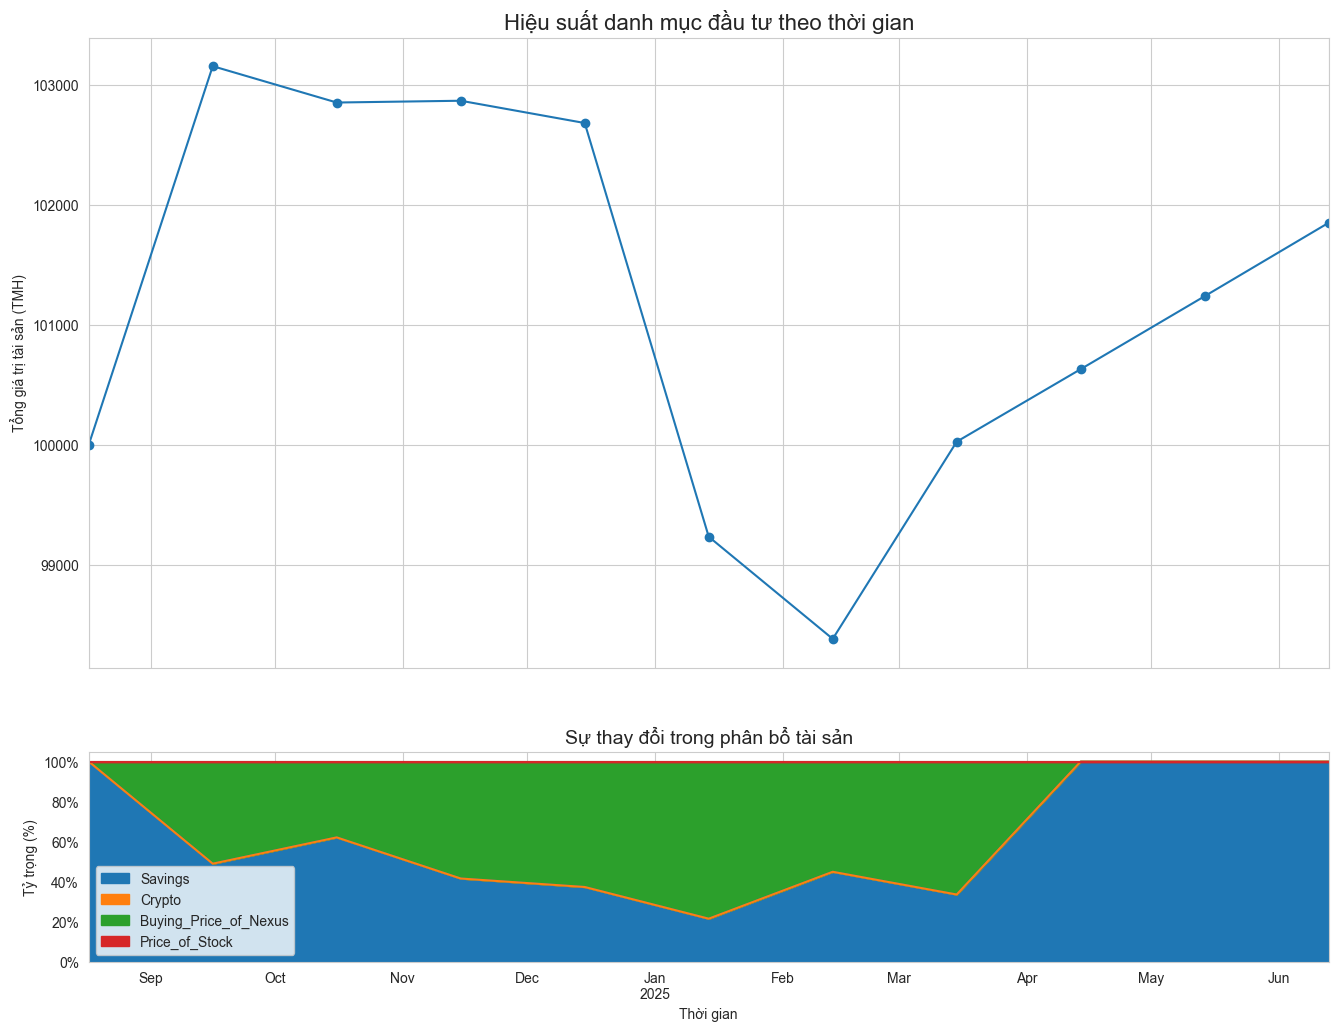

In [26]:
def run_backtest(
    historical_df,
    initial_capital,
    forecast_func,
    optimizer_func,
    train_window_size=30,
    test_months=12,
    days_per_month=30
):
    """
    Thực hiện kiểm thử quá khứ (backtesting) cho danh mục 4 TÀI SẢN.
    """
    capital = initial_capital
    
    # Vector 4 tài sản
    price_cols = ['Savings', 'Crypto', 'Buying_Price_of_Nexus', 'Price_of_Stock']
    # Bắt đầu với 100% vốn trong Gửi tiết kiệm
    current_weights = np.array([1.0, 0.0, 0.0, 0.0])
    
    # Chi phí giao dịch chỉ áp dụng cho tài sản rủi ro
    transaction_costs = {'Crypto': 0.0015, 'Price_of_Stock': 0.0015, 'Savings': 0, 'Buying_Price_of_Nexus': 0}
    
    # Lists để lưu lịch sử
    capital_history = [initial_capital]
    weights_history = [current_weights]
    dates_history = [historical_df.index[train_window_size -1]]

    # Vòng lặp chính qua 12 tháng
    for month in range(test_months):
        train_end_index = train_window_size + month * days_per_month
        test_end_index = train_end_index + days_per_month

        if test_end_index > len(historical_df):
            print(f"Dữ liệu không đủ để kiểm thử tháng {month + 1}. Dừng lại.")
            break
            
        # 1. Dự báo và Tối ưu hóa
        train_window = historical_df.iloc[:train_end_index]
        mu, sigma = forecast_func(train_window)
        
        # Bỏ các cột không cần thiết nếu có
        if 'Selling_Price_of_Nexus' in mu.index:
            mu = mu.drop('Selling_Price_of_Nexus')
            sigma = sigma.drop(columns='Selling_Price_of_Nexus', errors='ignore').drop('Selling_Price_of_Nexus', errors='ignore')

        target_weights = optimizer_func(mu, sigma)
        
        # 2. Tính toán hiệu suất và chi phí
        weights_change = np.abs(target_weights - current_weights)
        cost_rate_vector = np.array([transaction_costs.get(col, 0) for col in price_cols])
        total_transaction_cost = np.sum(weights_change * capital * cost_rate_vector)
        
        capital_after_rebalance = capital - total_transaction_cost
        
        # 3. Lợi nhuận thực tế trong tháng
        test_window = historical_df.iloc[train_end_index:test_end_index]
        asset_returns = (test_window[price_cols].iloc[-1] / test_window[price_cols].iloc[0]) - 1
        portfolio_return_month = np.sum(asset_returns * target_weights)
        
        # 4. Cập nhật vốn và lưu lịch sử
        capital = capital_after_rebalance * (1 + portfolio_return_month)
        current_weights = target_weights
        
        capital_history.append(capital)
        weights_history.append(current_weights)
        dates_history.append(test_window.index[-1])

    capital_history = pd.Series(data=capital_history, index=dates_history)
    weights_history = pd.DataFrame(data=weights_history, index=dates_history, columns=price_cols)
    
    return capital_history, weights_history

# --- Chạy lại mô phỏng và trực quan hóa ---
# Đảm bảo df có cột 'Savings' đã được tạo ở bước 1
initial_capital = 100000
capital_over_time, weights_over_time = run_backtest(
    historical_df=df.set_index('Time'),
    initial_capital=initial_capital,
    forecast_func=forecast_monthly_params,
    optimizer_func=optimize_weights,
    train_window_size=90, # Có thể thay đổi
    test_months=12
)

# In kết quả cuối cùng
print("\n--- KẾT QUẢ KIỂM THỬ (BACKTESTING) VỚI 4 TÀI SẢN ---")
print(f"Vốn ban đầu: {initial_capital:,.0f} TMH")
print(f"Vốn cuối kỳ: {capital_over_time.iloc[-1]:,.0f} TMH")
print(f"Tổng lợi nhuận: {(capital_over_time.iloc[-1]/initial_capital - 1):.2%}")

# Trực quan hóa kết quả
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
axes[0].plot(capital_over_time.index, capital_over_time, marker='o', linestyle='-')
axes[0].set_title('Hiệu suất danh mục đầu tư theo thời gian', fontsize=16)
axes[0].set_ylabel('Tổng giá trị tài sản (TMH)')
axes[0].grid(True)

weights_over_time.plot(kind='area', ax=axes[1], stacked=True)
axes[1].set_title('Sự thay đổi trong phân bổ tài sản', fontsize=14)
axes[1].set_ylabel('Tỷ trọng (%)')
axes[1].set_xlabel('Thời gian')
axes[1].set_yticklabels(['{:.0%}'.format(x) for x in axes[1].get_yticks()])

fig.tight_lightout()
plt.show()

# In ra ma trận trọng số
print("\n--- Ma trận trọng số (Weights Matrix) ---")
display((weights_over_time.round(4) * 100).to_string(float_format="%.2f%%"))

In [ ]:
# Chạy mô phỏng
initial_capital = 100000
capital_over_time, weights_over_time = run_backtest(
    historical_df=df.set_index('Time'), # Đảm bảo Time là index
    initial_capital=initial_capital,
    forecast_func=forecast_monthly_params,
    optimizer_func=optimize_weights
)

# In kết quả cuối cùng
print("\n--- KẾT QUẢ KIỂM THỬ (BACKTESTING) ---")
print(f"Vốn ban đầu: {initial_capital:,.0f} TMH")
print(f"Vốn cuối kỳ: {capital_over_time.iloc[-1]:,.0f} TMH")
print(f"Tổng lợi nhuận: {(capital_over_time.iloc[-1]/initial_capital - 1):.2%}")

# Trực quan hóa kết quả
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Biểu đồ 1: Giá trị danh mục theo thời gian
axes[0].plot(capital_over_time.index, capital_over_time, marker='o', linestyle='-')
axes[0].set_title('Hiệu suất danh mục đầu tư theo thời gian', fontsize=16)
axes[0].set_ylabel('Tổng giá trị tài sản (TMH)')
axes[0].grid(True)

# Biểu đồ 2: Sự thay đổi trọng số phân bổ
weights_over_time.plot(kind='area', ax=axes[1], stacked=True)
axes[1].set_title('Sự thay đổi trong phân bổ tài sản', fontsize=14)
axes[1].set_ylabel('Tỷ trọng (%)')
axes[1].set_xlabel('Thời gian')
axes[1].set_yticklabels(['{:.0%}'.format(x) for x in axes[1].get_yticks()])

plt.tight_layout()
plt.show()

# In ra ma trận trọng số 12x4 (thực tế là 13x3 hoặc 12x3 tùy cách bạn chạy)
print("\n--- Ma trận trọng số (Weights Matrix) ---")
display((weights_over_time.round(4) * 100).to_string(float_format="%.2f%%"))

ValueError: operands could not be broadcast together with shapes (4,) (3,) 


#### **Module 4: Module Mô phỏng & Kiểm thử (Simulation & Backtesting)**
*Mục đích: "Chạy" chiến lược đầu tư qua 12 tháng để đánh giá hiệu quả.*

* **Công việc 3.1: `generate_price_scenario()`**
    * **Mô tả**: Sử dụng mô hình **Geometric Brownian Motion (GBM)** từ file `scenario.ipynb` để tạo ra một chuỗi giá giả định cho 12 tháng tới. Điều này cho phép chúng ta kiểm thử chiến lược trên một kịch bản tương lai khả dĩ.
* **Công việc 3.2: `run_monthly_rebalancing_simulation(initial_capital, price_scenario)`**
    * **Mô tả**: Đây là hàm chính, thực hiện một vòng lặp trong 12 tháng. Tại **đầu mỗi tháng t**:
        1.  Lấy dữ liệu lịch sử đến thời điểm `t`.
        2.  Gọi hàm `forecast_monthly_params()` để lấy `μ` và `Σ` cho tháng `t`.
        3.  Gọi hàm `optimize_weights()` để tìm ra vector trọng số tối ưu `w_t`.
        4.  Lưu `w_t` vào ma trận kết quả.
        5.  Tính toán lợi nhuận thực tế trong tháng `t` dựa trên `price_scenario` và `w_t`, có trừ đi chi phí giao dịch.
        6.  Cập nhật tổng vốn và chuyển sang tháng `t+1`.


### 3. Cải tiến trong tương lai (Sau khi hoàn thành sườn chính)

1. Sau khi mô hình cơ sở hoạt động, chúng ta có thể tích hợp các quy tắc quản lý rủi ro nâng cao hơn:

    * **Cắt lỗ (Stop-loss)**: Trong vòng lặp của `run_monthly_rebalancing_simulation`, thay vì chỉ tính lợi nhuận cuối tháng, ta có thể kiểm tra giá hàng ngày. Nếu một tài sản giảm quá `x%`, hệ thống sẽ tự động bán và chuyển vốn về tiền mặt.
    * **Chốt lời (Take-profit)**: Tương tự, nếu tài sản đạt mức lợi nhuận kỳ vọng, có thể bán để hiện thực hóa lợi nhuận.


2. **Nâng cấp mô hình dự báo**: Sau khi có mô hình cơ sở, bạn có thể cải tiến bằng cách:
    * Thay thế việc tính phương sai/hiệp phương sai lịch sử bằng **mô hình GARCH** để có dự báo rủi ro `Σ` tốt hơn.
    * Thay thế việc tính lợi nhuận trung bình bằng **mô hình ARIMA** để có dự báo lợi nhuận `μ` tốt hơn. Tại sao dùng arima mà không là CAPM vì không có nhiều dữ liệu để benmark

3. **So sánh hiệu quả**: So sánh kết quả của chiến lược sau khi nâng cấp 
    * (ví dụ: Markowitz + GARCH) với mô hình cơ sở để xem việc sử dụng các mô hình dự báo phức tạp hơn có thực sự cải thiện hiệu suất đầu tư hay không.

Tóm lại, **Markowitz** là khung sườn để ra quyết định phân bổ, còn **ARIMA, GARCH, LightGBM** là các công cụ để giúp quyết định đó trở nên chính xác hơn.